In [2]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np

import gymnasium as gym
from gymnasium import spaces
import numpy as npimport 

import math
import random
import matplotlib
import matplotlib.pyplot as plt
from collections import namedtuple, deque
from itertools import count
from pprint import pprint
from typing import List, Tuple, Dict, Any, Union

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


actions: [QB, RB, WR, TE, K, DEF]

state: [
    next 15 QB FP

    next 30 RB FP

    next 30 WR FP

    next 15 TE FP

    next 15 Ks FP

    next 15 DEF FP

    team comps: 6 positions * 12 managers

    n until next pick (scaled  /12)

    round (scaled scaled /15)
    
    ]
    

120 future players
current team = 6 spots for QBs, 6 spots for k, 6 spots for def, 9 spots for RB, 9 for WR, 8 for TE (this allows full starters and anything else) = 44
+1 for picks remaining
+1 for number of opp picks before next pick
166 total

or 330 if i include a variance with each player


reward function: sum fpts when starting lineup is full, 0 when starting lineup not full

In [3]:
df_sleeper = pd.read_csv("data/sleeper/all_players.csv")
# df_sleeper = df_sleeper.loc[df_sleeper["rank_int"] < 50]
print(df_sleeper.shape)
df_sleeper.columns

(3670, 56)


Index(['sleeper_id', 'injury_notes', 'oddsjam_id', 'search_last_name',
       'college', 'team_abbr', 'birth_state', 'yahoo_id', 'search_first_name',
       'pandascore_id', 'years_exp', 'fantasy_positions', 'injury_status',
       'active', 'team', 'competitions', 'high_school', 'number', 'birth_city',
       'search_full_name', 'last_name', 'birth_country',
       'practice_description', 'depth_chart_order', 'fantasy_data_id',
       'status', 'injury_start_date', 'news_updated', 'age', 'search_rank',
       'practice_participation', 'opta_id', 'full_name', 'swish_id',
       'birth_date', 'rotowire_id', 'weight', 'height', 'stats_id', 'espn_id',
       'metadata', 'player_id', 'first_name', 'sport', 'injury_body_part',
       'position', 'gsis_id', 'sportradar_id', 'hashtag',
       'depth_chart_position', 'rotoworld_id', 'Player Id', 'positional_rank',
       'adp', 'adp_date', 'rank_int'],
      dtype='object')

In [4]:
SCORING = {
    'pass_yd': .04,
    'pass_td': 4,
    'pass_2pt': 2,
    'pass_int': -1,
    'rush_yd': .1,
    'rush_td': 6,
    'rush_2pt': 2,
    'rec_rcpt': .5,
    'rec_yd': .1,
    'rec_td': 6,
    'rec_2pt': 2,
    'fg_1_39_made': 3,
    'fg_40_49_made': 4,
    'fg_50_made': 5,
    'xp_missed': -1,
    'xp_made': 1,
    'def_td': 6,
    'def_int': 2,
    'def_sck': 1,
    'def_fum_rec': 2,
    'def_fum_forced': 1,
    'def_sfty': 2,
    'remainder': 1
}

POSITIONS = ['QB', 'RB', 'WR', 'TE', 'K', 'DEF']
STARTER_COMPOSITION = {'QB': 1, 'RB': 2, 'WR': 2, 'FLEX': 2, 'TE': 1, 'K': 1, 'DEF': 1}
TEAM_SIZE = 15

In [5]:
df_qb_proj = pd.read_csv("data/projections/QB_projections.csv")
df_rb_proj = pd.read_csv("data/projections/RB_projections.csv")
df_wr_proj = pd.read_csv("data/projections/WR_projections.csv")
df_te_proj = pd.read_csv("data/projections/TE_projections.csv")
df_k_proj = pd.read_csv("data/projections/K_projections.csv")
df_def_proj = pd.read_csv("data/projections/DEF_projections.csv")

df_qb_proj = df_qb_proj.loc[:, ["sleeper_id", "full_name", "team", "position", "source", "fpts"]].sort_values(by="fpts", ascending=False)
df_rb_proj = df_rb_proj.loc[:, ["sleeper_id", "full_name", "team", "position", "source", "fpts"]].sort_values(by="fpts", ascending=False)
df_wr_proj = df_wr_proj.loc[:, ["sleeper_id", "full_name", "team", "position", "source", "fpts"]].sort_values(by="fpts", ascending=False)
df_te_proj = df_te_proj.loc[:, ["sleeper_id", "full_name", "team", "position", "source", "fpts"]].sort_values(by="fpts", ascending=False)
df_k_proj = df_k_proj.loc[:, ["sleeper_id", "full_name", "team", "position", "source", "fpts"]].sort_values(by="fpts", ascending=False)
df_def_proj = df_def_proj.loc[:, ["sleeper_id", "full_name", "team", "position", "source", "fpts"]].sort_values(by="fpts", ascending=False)

df_proj = pd.concat([df_qb_proj, df_rb_proj, df_wr_proj, df_te_proj, df_k_proj, df_def_proj])
df_proj.columns

df_proj_agg = df_proj.groupby('sleeper_id')['fpts'].agg(['mean', 'std']).reset_index()
df_proj_agg['sleeper_id'] = df_proj_agg['sleeper_id'].astype(str)


df_players = df_proj_agg.merge(df_sleeper.loc[:, ['sleeper_id', 'full_name', 'position', 'team']], 
                                on='sleeper_id', 
                                how='left')
print(df_players.shape)
df_players = df_players.dropna(subset=['mean', 'std'])
print(df_players.shape)




(796, 6)
(647, 6)


In [6]:

# set up matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display
plt.ion()

# if GPU is to be used
device = torch.device(
    "cuda" if torch.cuda.is_available() else
    "mps" if torch.backends.mps.is_available() else
    "cpu"
)



# Init environment and RL network

In [7]:
from rl import (
    DQN, ReplayMemory, Transition, DraftEnv,
    NUM_MGRS, NUM_DRAFT_ROUNDS, ACTION_SPACE_DIM, 
    STATE_SPACE_DIM, STARTER_COMPOSITION
    )

In [8]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 100000
TAU = 0.005
LR = 1e-4

env = DraftEnv(df_players)

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

mgr_networks = {i: {} for i in range(NUM_MGRS)}
for mgr in mgr_networks.values():
    mgr["policy"] = DQN(n_observations, n_actions).to(device)
    mgr["target"] = DQN(n_observations, n_actions).to(device)
    mgr["optimizer"] = optim.AdamW(mgr["policy"].parameters(), lr=LR, amsgrad=True)
    mgr["memory"] = ReplayMemory(10000)
    mgr["target"].load_state_dict(mgr["policy"].state_dict())

steps_done = 0



In [16]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer
BATCH_SIZE = 128
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 10000
TAU = 0.005
LR = 1e-4

env = DraftEnv(df_players)

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

mgr_networks = {i: {} for i in range(NUM_MGRS)}
for mgr in mgr_networks.values():
    mgr["policy"] = DQN(n_observations, n_actions).to(device)
    mgr["target"] = DQN(n_observations, n_actions).to(device)
    mgr["optimizer"] = optim.AdamW(mgr["policy"].parameters(), lr=LR, amsgrad=True)
    mgr["memory"] = ReplayMemory(10000)
    mgr["target"].load_state_dict(mgr["policy"].state_dict())

steps_done = 0



In [17]:

def select_action(state, policy_net, env, device):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        if random.random() < 0.5:
            return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)
        else:
            return torch.tensor([[env.reasonable_option()]], device=device, dtype=torch.long)


def optimize_model(memory, policy_net, target_net, optimizer):
    if len(memory) < BATCH_SIZE:
        return 
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()
    
    return loss

In [18]:
if torch.cuda.is_available() or torch.backends.mps.is_available():
    num_episodes = 600
    # num_episodes = 50
else:
    num_episodes = 50

losses = {mgr_num: [] for mgr_num in range(NUM_MGRS)}
drafts = []
rewards = []


In [19]:

for i_episode in range(num_episodes):
    env.reset()
    print(f"Episode: {i_episode}")
    for _, row in env.draft.iterrows():
        # print(f"Round: {row[1]['round']}, Manager: {row[1]['mgr']}")
        mgr_num = row["mgr"]
        mgr = mgr_networks[mgr_num]
        
        state = torch.tensor(env.get_state(), dtype=torch.float32, device=device).unsqueeze(0)
        action = select_action(state, mgr["policy"], env, device)
        observation, reward, terminated, info = env.step(action.item())
        reward = torch.tensor([reward], dtype=torch.float32, device=device)

        done = terminated 
        
        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        mgr["memory"].push(state, action, next_state, reward)
        
        # Move to the next state
        state = next_state
        
        # Perform one step of the optimization (on the policy network)
        loss = optimize_model(mgr["memory"], mgr["policy"], mgr["target"], mgr["optimizer"])
        loss = loss.item() if loss is not None else None
        losses[mgr_num].append(loss)
        
        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = mgr["target"].state_dict()
        policy_net_state_dict = mgr["policy"].state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        mgr["target"].load_state_dict(target_net_state_dict)
    
    round_rewards = {}
    drafts.append(env.draft.copy())
    for mgr_num in range(NUM_MGRS):
        round_rewards[mgr_num] = env.compute_reward(mgr_num)
        rewards.append(round_rewards)
        
    print(f"Total round rewards:{np.sum(list(round_rewards.values()))}")
    # sum losses
    cur_loss_sum = 0  # Initialize the total sum to 0
    for mgr_num, loss_list in losses.items():
        cur_loss_sum += loss_list[-1]  if loss_list[-1] is not None else 0

    print(f"Average loss: {cur_loss_sum / NUM_MGRS}")
    eps_threshold = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    print(f"Epsilon: {eps_threshold}")
    
        

        
print('Complete')


Episode: 0
Total round rewards:4.411368716540686
Average loss: 0.0
Epsilon: 0.8848368775045556
Episode: 1
Total round rewards:0
Average loss: 0.0
Epsilon: 0.8699442494606546
Episode: 2
Total round rewards:4.22823795832355
Average loss: 0.0
Epsilon: 0.8553172905265286
Episode: 3
Total round rewards:3.9198546658745475
Average loss: 0.0
Epsilon: 0.8409512614395249
Episode: 4
Total round rewards:0
Average loss: 0.0
Epsilon: 0.826841507480544
Episode: 5
Total round rewards:4.192964230063352
Average loss: 0.0
Epsilon: 0.8129834569658697
Episode: 6
Total round rewards:3.919157431781449
Average loss: 0.0
Epsilon: 0.7993726197659037
Episode: 7
Total round rewards:0
Average loss: 0.0
Epsilon: 0.7860045858503243
Episode: 8
Total round rewards:4.081325867908392
Average loss: 0.02221934640935312
Epsilon: 0.772875023859198
Episode: 9
Total round rewards:0
Average loss: 0.004372117400635034
Epsilon: 0.7599796796995812
Episode: 10
Total round rewards:4.412106120139802
Average loss: 0.00223177638448153

KeyboardInterrupt: 

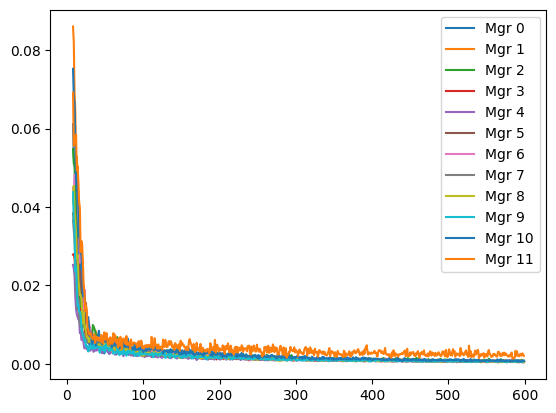

In [11]:

# plot losses for each manager
for i, loss in losses.items():
    plt.plot(loss)
# add legend for each manager
plt.legend([f"Mgr {i}" for i in losses.keys()])
plt.ioff()
plt.show()


In [18]:

# pd.set_option('display.max_rows', None)  # Show all rows
# pd.set_option('display.max_columns', None)  # Show all columns
# pd.set_option('display.width', None)  # Automatically adjust the display width
# pd.set_option('display.max_colwidth', None)  # Show full content of each column
# # display(env.draft.loc[env.draft["mgr"] == 0])
# display(env.)
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')
# pd.reset_option('display.width')
# pd.reset_option('display.max_colwidth')

print(env.draft.loc[env.draft["mgr"] == 0])
# env.compute_reward(1)

for i in range(NUM_MGRS):
    print(f"Manager {i} reward: {env.compute_reward(i)}")

     round  mgr sleeper_id           full_name team position   fp_mean  \
0        0    0       4984          Josh Allen  BUF       QB       1.0   
23       1    0        CLE    Cleveland Browns  CLE      DEF  0.423722   
24       2    0       3321         Tyreek Hill  MIA       WR  0.749326   
47       3    0       6794    Justin Jefferson  MIN       WR  0.701534   
48       4    0       8183         Brock Purdy   SF       QB  0.808508   
71       5    0        HOU      Houston Texans  HOU      DEF  0.381082   
72       6    0       7569        Nico Collins  HOU       WR  0.566837   
95       7    0       5846          DK Metcalf  SEA       WR  0.545708   
96       8    0         NO  New Orleans Saints   NO      DEF  0.371778   
119      9    0        SEA    Seattle Seahawks  SEA      DEF  0.351803   
120     10    0        IND  Indianapolis Colts  IND      DEF  0.351075   
143     11    0         LV   Las Vegas Raiders   LV      DEF  0.346173   
144     12    0       9224         Cha